In [47]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
# For use in Jupyter notebooks only:
import pandas as pd


# Creacion de referencias

In [48]:
chromosome_length = 4
solutions = 2
references = np.zeros((solutions, chromosome_length))
references[0][0]=1
references[0][1]=0
references[0][2]=0
references[0][3]=1
references[1][0]=0
references[1][1]=1
references[1][2]=1
references[1][3]=0

In [49]:
datos = pd.read_csv('Transaccionalidad.csv',sep=';')

In [50]:
datos = datos.to_numpy()

In [51]:
# Ciclo para restriccion canal
for i in range(0,datos.shape[0]):
    if datos[i][0]=='Tradicional':
        datos[i][0] = 0
    else:
        datos[i][0] = 1


In [52]:
# Ciclo para restriccion edad
for i in range(0,datos.shape[0]):
    if datos[i][1]<60:
        datos[i][1] = 0
    else:
        datos[i][1] = 1


In [53]:
# Ciclo para restriccion tipo costo
for i in range(0,datos.shape[0]):
    if datos[i][2]=='Mayor':
        datos[i][2] = 0
    else:
        datos[i][2] = 1

In [54]:
# Ciclo para restriccion edad
for i in range(0,datos.shape[0]):
    if datos[i][3]<5000000:
        datos[i][3] = 0
    else:
        datos[i][3] = 1


In [56]:
population = datos

In [60]:
import random as rn
import numpy as np
import matplotlib.pyplot as plt
# For use in Jupyter notebooks only:

# Create reference solutions
# --------------------------

def create_reference_solutions(chromosome_length, solutions):
    """
    Function to create reference chromosomes that will mimic an ideal solution 
    """
    references = np.zeros((solutions, chromosome_length))
    number_of_ones = int(chromosome_length / 2)
    
    for solution in range(solutions):
        # Build an array with an equal mix of zero and ones
        reference = np.zeros(chromosome_length)
        reference[0: number_of_ones] = 1
    
        # Shuffle the array to mix the zeros and ones
        np.random.shuffle(reference)
        references[solution,:] = reference
    
    return references


# Evaluate solutions
# ------------------

def calculate_fitness(reference, population):
    """
    Calculate how many binary digits in each solution are the same as our 
    reference solution.
    """
    # Create an array of True/False compared to reference
    identical_to_reference = population == reference
    # Sum number of genes that are identical to the reference
    fitness_scores = identical_to_reference.sum(axis=1)
    
    return fitness_scores 


def score_population(population, references):
    """
    Loop through all reference solutoins and request score/fitness of
    populaiton against that reference solution.
    """
    scores = np.zeros((population.shape[0], references.shape[0]))
    for i, reference in enumerate(references):
        scores[:,i] = calculate_fitness(reference, population)
        
    return scores 

# Calculate crowding and select a population based on crowding scores
# -------------------------------------------------------------------
    
def calculate_crowding(scores):
    """
    Crowding is based on a vector for each individual
    All scores are normalised between low and high. For any one score, all
    solutions are sorted in order low to high. Crowding for chromsome x
    for that score is the difference between the next highest and next
    lowest score. Total crowding value sums all crowding for all scores
    """
    
    population_size = len(scores[:, 0])
    number_of_scores = len(scores[0, :])

    # create crowding matrix of population (row) and score (column)
    crowding_matrix = np.zeros((population_size, number_of_scores))

    # normalise scores (ptp is max-min)
    normed_scores = (scores - scores.min(0)) / scores.ptp(0)

    # calculate crowding distance for each score in turn
    for col in range(number_of_scores):
        crowding = np.zeros(population_size)

        # end points have maximum crowding
        crowding[0] = 1
        crowding[population_size - 1] = 1

        # Sort each score (to calculate crowding between adjacent scores)
        sorted_scores = np.sort(normed_scores[:, col])

        sorted_scores_index = np.argsort(
            normed_scores[:, col])

        # Calculate crowding distance for each individual
        crowding[1:population_size - 1] = \
            (sorted_scores[2:population_size] -
             sorted_scores[0:population_size - 2])

        # resort to orginal order (two steps)
        re_sort_order = np.argsort(sorted_scores_index)
        sorted_crowding = crowding[re_sort_order]

        # Record crowding distances
        crowding_matrix[:, col] = sorted_crowding

    # Sum croding distances of each score
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances


def reduce_by_crowding(scores, number_to_select):
    """
    This function selects a number of solutions based on tournament of
    crowding distances. Two members of the population are picked at
    random. The one with the higher croding dostance is always picked
    """
    population_ids = np.arange(scores.shape[0])

    crowding_distances = calculate_crowding(scores)

    picked_population_ids = np.zeros((number_to_select))

    picked_scores = np.zeros((number_to_select, len(scores[0, :])))

    for i in range(number_to_select):

        population_size = population_ids.shape[0]

        fighter1ID = rn.randint(0, population_size - 1)

        fighter2ID = rn.randint(0, population_size - 1)

        # If fighter # 1 is better
        if crowding_distances[fighter1ID] >= crowding_distances[
            fighter2ID]:

            # add solution to picked solutions array
            picked_population_ids[i] = population_ids[
                fighter1ID]

            # Add score to picked scores array
            picked_scores[i, :] = scores[fighter1ID, :]

            # remove selected solution from available solutions
            population_ids = np.delete(population_ids, (fighter1ID),
                                       axis=0)

            scores = np.delete(scores, (fighter1ID), axis=0)

            crowding_distances = np.delete(crowding_distances, (fighter1ID),
                                           axis=0)
        else:
            picked_population_ids[i] = population_ids[fighter2ID]

            picked_scores[i, :] = scores[fighter2ID, :]

            population_ids = np.delete(population_ids, (fighter2ID), axis=0)

            scores = np.delete(scores, (fighter2ID), axis=0)

            crowding_distances = np.delete(
                crowding_distances, (fighter2ID), axis=0)

    # Convert to integer 
    picked_population_ids = np.asarray(picked_population_ids, dtype=int)
    
    return (picked_population_ids)

# Pareto selecion
# ---------------
    
def identify_pareto(scores, population_ids):
    """
    Identifies a single Pareto front, and returns the population IDs of
    the selected solutions.
    """
    
    population_size = scores.shape[0]
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by out 'j' point
            if all(scores[j] >= scores[i]) and any(scores[j] > scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]


def build_pareto_population(
        population, scores, minimum_population_size, maximum_population_size):
    """
    As necessary repeats Pareto front selection to build a population within
    defined size limits. Will reduce a Pareto front by applying crowding 
    selection as necessary.    
    """
    unselected_population_ids = np.arange(population.shape[0])
    all_population_ids = np.arange(population.shape[0])
    pareto_front = []
    while len(pareto_front) < minimum_population_size:
        temp_pareto_front = identify_pareto(
                scores[unselected_population_ids, :], unselected_population_ids)
        
        # Check size of total parteo front. 
        # If larger than maximum size reduce new pareto front by crowding
        combined_pareto_size = len(pareto_front) + len(temp_pareto_front)
        if combined_pareto_size > maximum_population_size:
            number_to_select = combined_pareto_size - maximum_population_size
            selected_individuals = (reduce_by_crowding(
                    scores[temp_pareto_front], number_to_select))
            temp_pareto_front = temp_pareto_front[selected_individuals]
        
        # Add latest pareto front to full Pareto front
        pareto_front = np.hstack((pareto_front, temp_pareto_front))
        
    
        # Update unslected population ID by using sets to find IDs in all
        # ids that are not in the selected front
        unselected_set = set(all_population_ids) - set(pareto_front)
        unselected_population_ids = np.array(list(unselected_set))

    population = population[pareto_front.astype(int)]
    return population

# Population functions
# --------------------
    
def create_population(individuals, chromosome_length):
    """
    Create random population with given number of individuals and chroosome
    length.
    """
    
    # Set up an initial array of all zeros
    population = np.zeros((individuals, chromosome_length))
    # Loop through each row (individual)
    for i in range(individuals):
        # Choose a random number of ones to create
        ones = rn.randint(0, chromosome_length)
        # Change the required number of zeros to ones
        population[i, 0:ones] = 1
        # Sfuffle row
        np.random.shuffle(population[i])
    
    return population

def breed_by_crossover(parent_1, parent_2):
    """
    Combine two parent chromsomes by crossover to produce two children.
    """
    # Get length of chromosome
    chromosome_length = len(parent_1)
    
    # Pick crossover point, avoding ends of chromsome
    crossover_point = rn.randint(1,chromosome_length-1)
    
    # Create children. np.hstack joins two arrays
    child_1 = np.hstack((parent_1[0:crossover_point],
                        parent_2[crossover_point:]))
    
    child_2 = np.hstack((parent_2[0:crossover_point],
                        parent_1[crossover_point:]))
    
    # Return children
    return child_1, child_2


def randomly_mutate_population(population, mutation_probability):
    """
    Randomly mutate population with a given individual gene mutation
    probability. Individual gene may switch between 0/1.
    """
    
    # Apply random mutation
    random_mutation_array = np.random.random(size=(population.shape))
    
    random_mutation_boolean = \
        random_mutation_array <= mutation_probability

    population[random_mutation_boolean] = \
    np.logical_not(population[random_mutation_boolean])
    
    # Return mutation population
    return population


def breed_population(population):
    """
    Create child population by repetedly calling breeding function (two parents
    producing two children), applying genetic mutation to the child population,
    combining parent and child population, and removing duplice chromosomes.
    """
    # Create an empty list for new population
    new_population = []
    population_size = population.shape[0]
    # Create new popualtion generating two children at a time
    for i in range(int(population_size/2)):
        parent_1 = population[rn.randint(0, population_size-1)]
        parent_2 = population[rn.randint(0, population_size-1)]
        child_1, child_2 = breed_by_crossover(parent_1, parent_2)
        new_population.append(child_1)
        new_population.append(child_2)
    
    # Add the child population to the parent population
    # In this method we allow parents and children to compete to be kept
    population = np.vstack((population, np.array(new_population)))
    #population = np.unique(population, axis=0)
    
    return population

Generation (out of 250): 0 
Generation (out of 250): 10 
Generation (out of 250): 20 
Generation (out of 250): 30 
Generation (out of 250): 40 
Generation (out of 250): 50 
Generation (out of 250): 60 
Generation (out of 250): 70 
Generation (out of 250): 80 
Generation (out of 250): 90 
Generation (out of 250): 100 
Generation (out of 250): 110 
Generation (out of 250): 120 
Generation (out of 250): 130 
Generation (out of 250): 140 
Generation (out of 250): 150 
Generation (out of 250): 160 
Generation (out of 250): 170 
Generation (out of 250): 180 
Generation (out of 250): 190 
Generation (out of 250): 200 
Generation (out of 250): 210 
Generation (out of 250): 220 
Generation (out of 250): 230 
Generation (out of 250): 240 


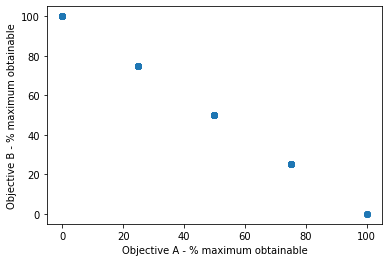

In [63]:
chromosome_length = 4
maximum_generation = 250
minimum_population_size = 10
maximum_population_size = 1000


# Create starting population

# Now we'll go through the generations of genetic algorithm

for generation in range(maximum_generation):
    if generation %10 ==0:
        print ('Generation (out of %i): %i '%(maximum_generation, generation))
    
    # Brred
    population = breed_population(population)
    
    # Score population
    scores = score_population(population, references)
    
    # Build pareto front
    population = build_pareto_population(
            population, scores, minimum_population_size, maximum_population_size)


# Get final pareto front
scores = score_population(population, references)
population_ids = np.arange(population.shape[0]).astype(int)
pareto_front = identify_pareto(scores, population_ids)
population = population[pareto_front, :]
scores = scores[pareto_front]

# Plot Pareto front (for two scores only)  
x = scores[:, 0]/chromosome_length*100
y = scores[:, 1]/chromosome_length*100
plt.xlabel('Objective A - % maximum obtainable')
plt.ylabel('Objective B - % maximum obtainable')

plt.scatter(x,y)
plt.savefig('pareto.png')
plt.show()